# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imsave
import pandas as pd
import csv
import random
import math

from __future__ import print_function
import os
from functools import partial
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Curate Data

In [2]:
# consts
A_B_PENALTY = 0.1
NO_SEED_PLACEHOLDER = 35

# load detailed results
reader = csv.reader(open("RegularSeasonDetailedResults.csv", "rt"), delimiter=",")
read = list(reader)
del read[0]

# load seeds
reader = csv.reader(open("TourneySeeds.csv", "rt"), delimiter=",")
read_seeds = list(reader)
del read_seeds[0]
   

# build dataset
data = []
target = []
std = {} # seasonal team data struct
seed_dict = {}

# build seed dataset
for i in range(len(read_seeds)):
    year = read_seeds[i][0]
    seedstr = read_seeds[i][1]
    team = read_seeds[i][2]
    
    seed = None
    if len(seedstr) == 4:
        if seedstr[3] == 'a':
            seed = int(read_seeds[i][1][1:3]) - A_B_PENALTY
        else:
            seed = int(read_seeds[i][1][1:3]) + A_B_PENALTY
    else:
        seed = int(read_seeds[i][1][1:])
    
    
    if not seed_dict.get(year):
        seed_dict[year] = {}
        
    seed_dict[year][team] = seed
    
# build with detailed results
for i in range(len(read)):
    season = read[i][0]
    wteam = read[i][2]
    lteam = read[i][4]
    wscore = read[i][3]
    lscore = read[i][5]
    
    wcurrData = read[i][8:20]
    wcurrData.append(wscore)
    if not seed_dict[season].get(wteam):
        wcurrData.append(NO_SEED_PLACEHOLDER)
    else:
        wcurrData.append(seed_dict[season][wteam])
    wcurrData = [ int(x) for x in wcurrData ]
    
    lcurrData = read[i][21:33]
    lcurrData.append(lscore)
    if not seed_dict[season].get(lteam):
        lcurrData.append(NO_SEED_PLACEHOLDER)
    else:
        lcurrData.append(seed_dict[season][lteam])
    lcurrData = [ int(x) for x in lcurrData ]
        
    # new season
    if not std.get(season):
        std[season] = {}
        
    # winning team data
    if not std[season].get(wteam):
        std[season][wteam] = [1, wcurrData] # (num games, data)
    else:
        prevNumGames = std[season][wteam][0]
        for j in range(len(std[season][wteam][1])):
            std[season][wteam][1][j] *= prevNumGames / (prevNumGames + 1)
            std[season][wteam][1][j] += wcurrData[j] * 1 / (prevNumGames + 1)
        
        std[season][wteam][0] += 1
        
    # losing team data  
    if not std[season].get(lteam):
        std[season][lteam] = [1, lcurrData] # (num games, data)
    else:
        prevNumGames = std[season][lteam][0]
        for j in range(len(std[season][lteam][1])):
            std[season][lteam][1][j] *= prevNumGames / (prevNumGames + 1)
            std[season][lteam][1][j] += lcurrData[j] * 1 / (prevNumGames + 1)
        
        std[season][lteam][0] += 1
        
    # build curr data
    currData = std[season][wteam][1] + std[season][lteam][1]
    data.append(currData)
    target.append(1)
    currData = std[season][lteam][1] + std[season][wteam][1]
    data.append(currData)
    target.append(0)
    
# convert to np array
data = np.array(data).astype("float")
target = np.array(target).astype("float")
target = np.expand_dims(target, -1)

# normalize
data /= np.amax(data)
normalization_array = np.array([1 / np.amax(data, axis=0)] * data.shape[0])
data = data * normalization_array

# randomize
randomization_index = np.arange(data.shape[0])
np.random.shuffle(randomization_index)

data = data[randomization_index]
target = target[randomization_index]

# print for debug
print('Data:')
print(data)
print('Target:')
print(target)

Data:
[[ 0.44515306  0.5939441   0.26623377 ...,  0.06072874  0.45726496  1.        ]
 [ 0.47410714  0.60706522  0.28409091 ...,  0.3434903   0.56176901
   0.02857143]
 [ 0.4408867   0.61244378  0.22570533 ...,  0.18330309  0.57447318
   0.42857143]
 ..., 
 [ 0.48214286  0.66149068  0.37012987 ...,  0.28571429  0.55059524  1.        ]
 [ 0.46173469  0.63509317  0.38961039 ...,  0.07894737  0.56597222  1.        ]
 [ 0.46364796  0.61451863  0.22402597 ...,  0.05473684  0.46305556  1.        ]]
Target:
[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 1.]
 [ 1.]]


In [3]:
# seperate data
TRAIN_FRAC = 0.7
VALID_FRAC = 0.1

trainDimEnd = math.floor(data.shape[0] * TRAIN_FRAC)
validDimEnd = math.floor(data.shape[0] * (TRAIN_FRAC + VALID_FRAC))

trainData = data[:trainDimEnd]
trainTarget = target[:trainDimEnd]
validData = data[trainDimEnd:validDimEnd]
validTarget = target[trainDimEnd:validDimEnd]
testData = data[validDimEnd:]
testTarget = target[validDimEnd:]

# print for debug
print('Train Dimensions:')
print(trainData.shape)
print(trainTarget.shape)
print('Valid Dimensions:')
print(validData.shape)
print(validTarget.shape)
print('Test Dimensions:')
print(testData.shape)
print(testTarget.shape)

Train Dimensions:
(107290, 28)
(107290, 1)
Valid Dimensions:
(15327, 28)
(15327, 1)
Test Dimensions:
(30655, 28)
(30655, 1)


# Train

In [4]:
def neural_net_block(prev_layer, layer_size):
    PREV_LAYER_DIM = prev_layer.get_shape().as_list()[1]
    XAVIER_INIT_STDDEV = tf.cast(3 / (layer_size + PREV_LAYER_DIM), tf.float32)

    # initialize variables
    layer_weights = tf.Variable(tf.random_normal([PREV_LAYER_DIM, layer_size], stddev=XAVIER_INIT_STDDEV), name='weights')
    layer_biases = tf.Variable(tf.zeros([1, layer_size]), name='bias')

    # calculate output
    layer_z = tf.matmul(prev_layer, layer_weights) + layer_biases
    
    # return all in order to have external handle for variables
    return layer_z, layer_weights, layer_biases

Epoch 40 / 1000 : 0.555372 loss


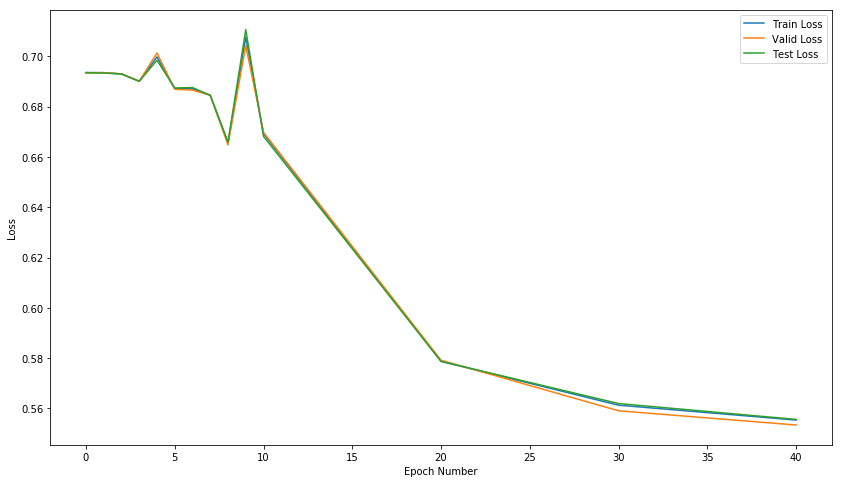

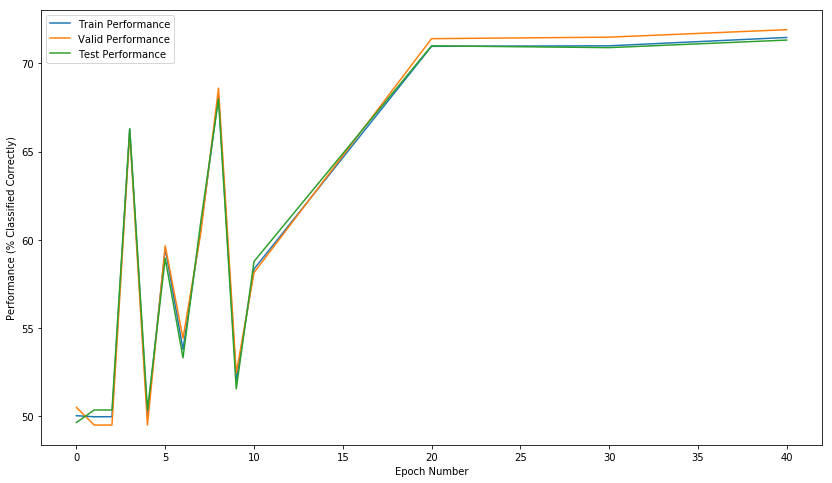

KeyboardInterrupt: 

In [5]:
# parameters
MAX_NUM_EPOCHS = 1000
PRINT_FREQUENCY = 0.01
SAVE_FREQUENCY = 0.25
η = 0.01
λ = 0.0003
input_shape = [None, 28]
label_shape = [None, 1]
tf.set_random_seed(7)

# profiles
train_loss_profile = []
valid_loss_profile = []
test_loss_profile = []
train_performance_profile = []
valid_performance_profile = []
test_performance_profile = []
epoch_profile = []

# reset for graph visualization
# tf.reset_default_graph()

# placeholders
x = tf.placeholder(tf.float32, shape=input_shape, name='x')
y = tf.placeholder(tf.float32, shape=label_shape, name='y')

# prediction
z_1, W_1, b_1 = neural_net_block(x, 500)
z_2, W_2, b_2 = neural_net_block(tf.nn.relu(z_1), 300)
z_3, W_3, b_3 = neural_net_block(tf.nn.relu(z_2), 300)
z_4, W_4, b_4 = neural_net_block(tf.nn.relu(z_3), label_shape[1])
y_hat = z_4
y_hat_out = tf.sigmoid(y_hat)

# loss
cross_entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y_hat, y)) \
                                    + (λ / 2) * (tf.reduce_sum(tf.square(W_1)) + tf.reduce_sum(tf.square(W_2)))

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=η)
train = optimizer.minimize(loss=cross_entropy_loss)

# init
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
                         
# begin training
for epoch in range(MAX_NUM_EPOCHS + 1):
    train_res = sess.run(train, feed_dict={x:trainData, y:trainTarget})

    # print progress periodically
    if epoch % (MAX_NUM_EPOCHS * PRINT_FREQUENCY) == 0 or epoch < 10:
        # check overall loss 
        train_loss_profile.append(sess.run(cross_entropy_loss, feed_dict={x:trainData, y:trainTarget}))
        valid_loss_profile.append(sess.run(cross_entropy_loss, feed_dict={x:validData, y:validTarget}))
        test_loss_profile.append(sess.run(cross_entropy_loss, feed_dict={x:testData, y:testTarget}))

        # check overall performance
        train_y_hat = sess.run(y_hat_out, feed_dict={x:trainData, y:trainTarget})
        train_performance_profile.append(np.sum(np.all(np.rint(train_y_hat) == trainTarget, axis=1)) / trainTarget.shape[0] * 100)
        valid_y_hat = sess.run(y_hat_out, feed_dict={x:validData, y:validTarget})
        valid_performance_profile.append(np.sum(np.all(np.rint(valid_y_hat) == validTarget, axis=1)) / validTarget.shape[0] * 100)
        test_y_hat = sess.run(y_hat_out, feed_dict={x:testData, y:testTarget})
        test_performance_profile.append(np.sum(np.all(np.rint(test_y_hat) == testTarget, axis=1)) / testTarget.shape[0] * 100)
        
        # append epoch profile
        epoch_profile.append(epoch)
        
        # clear plot
        clear_output(wait=True)
        print('Epoch', epoch, '/', MAX_NUM_EPOCHS, ':', train_loss_profile[-1], 'loss')
        
        # plot losses
        plt.figure(figsize=(14, 8))
        plt.plot(epoch_profile, train_loss_profile, label='Train Loss')
        plt.plot(epoch_profile, valid_loss_profile, label='Valid Loss')
        plt.plot(epoch_profile, test_loss_profile, label='Test Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch Number')
        plt.legend()
        plt.savefig('2.2.2-Loss.png')
        plt.show()
        
        # plot performance
        plt.figure(figsize=(14, 8))
        plt.plot(epoch_profile, train_performance_profile, label='Train Performance')
        plt.plot(epoch_profile, valid_performance_profile, label='Valid Performance')
        plt.plot(epoch_profile, test_performance_profile, label='Test Performance')
        plt.ylabel('Performance (% Classified Correctly)')
        plt.xlabel('Epoch Number')
        plt.legend()
        plt.savefig('2.2.2-Performance.png')
        plt.show()
        
    # save progress periodically
    if epoch % round(MAX_NUM_EPOCHS * SAVE_FREQUENCY) == 0:
        save_path = saver.save(sess, ".\model-2.2.2-v2.ckpt")
        print('Epoch', epoch, '/', MAX_NUM_EPOCHS, ': Model saved in file ', save_path)
        
        
# visualize the computation graph
# show_graph(tf.get_default_graph().as_graph_def())

In [6]:
# save
saver.save(sess, ".\model-2.2.2-v2.ckpt")

'.\\model-2.2.2-v2.ckpt'

In [7]:
# final accuracy
final_test_pred = sess.run(y_hat_out, feed_dict={x:testData, y:testTarget})
np.sum(np.all(np.rint(final_test_pred) == testTarget, axis=1)) / testTarget.shape[0] * 100

72.27858424400587

In [8]:
# load seeds
reader = csv.reader(open("TourneySeeds.csv", "rt"), delimiter=",")
read_seeds = list(reader)
del read_seeds[0]


# load slots
reader = csv.reader(open("TourneySlots.csv", "rt"), delimiter=",")
read_slots = list(reader)
del read_slots[0]

# vars
curr_year_seeds = {}
curr_year_r1 = []
r1 = [[],[],[],[]]

# build seed dataset
for i in range(len(read_seeds)):
    year = read_seeds[i][0]
    seedstr = read_seeds[i][1]
    team = read_seeds[i][2]
    
    if year != '2017':
        continue
       
    curr_year_seeds[team] = seedstr
    

# build slot data
# for i in range(len(read_slots)):
#     if read_slots[i][0] != '2017':
#         continue
        
#     teamSeed1 = read_slots[i][2]
#     teamSeed2 = read_slots[i][3]
    
#     team1 = curr_year_seeds[teamSeed1]
#     team2 = curr_year_seeds[teamSeed2]
    
#     curr_year_r1.append((team1, team2))
    
#     r1[0].append(teamSeed1)
#     r1[1].append(team1)
#     r1[2].append(teamSeed2)
#     r1[3].append(team3)

In [9]:
# load teams
reader = csv.reader(open("Teams.csv", "rt"), delimiter=",")
read_teams = list(reader)
del read_teams[0]

teamIndex = {}
for i in range(len(read_teams)):
    teamIndex[read_teams[i][0]] = read_teams[i][1]

In [10]:
# load curr year predictions
submissionData = []
teamMatchup = []
team1Name = []
team2Name = []

# build value list
dataList = []
for team, data in std['2017'].items():
    if curr_year_seeds.get(team):
        dataList.append([team, data[1]])
        
# sort
dataList.sort(key=lambda x: x[0])
    
# build submisison dataset
for i in range(len(dataList)):
    for j in range(i+1, len(dataList)):
        submissionData.append(dataList[i][1] + dataList[j][1])
        teamMatchup.append('2017_' + dataList[i][0] + '_' + dataList[j][0])
        team1Name.append(teamIndex[dataList[i][0]])
        team2Name.append(teamIndex[dataList[j][0]])
        
submissionData = np.array(submissionData).astype("float")

# normalize
submissionData /= np.amax(submissionData)
normalization_array = np.array([1 / np.amax(submissionData, axis=0)] * submissionData.shape[0])
submissionData = submissionData * normalization_array

In [11]:
# generate predictions
submissionPredictions = sess.run(y_hat_out, feed_dict={x:submissionData})
submissionPredictions = np.reshape(submissionPredictions, [submissionPredictions.shape[0]])

In [12]:
#lineup data
df = pd.DataFrame({'Id':teamMatchup, \
              'Pred':submissionPredictions})
df = df.sort('Id')

df.to_csv("MM2017_prediction-v2.csv", index=False)
df

c:\users\sev\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Id,Pred
0,2017_1112_1116,0.435291
1,2017_1112_1124,0.576536
2,2017_1112_1137,0.809700
3,2017_1112_1139,0.640510
4,2017_1112_1153,0.440121
5,2017_1112_1166,0.660736
6,2017_1112_1173,0.460194
7,2017_1112_1181,0.287773
8,2017_1112_1190,0.606185
9,2017_1112_1195,0.884306
